# Project Title
"A Risk- Adjusted Time-Series Trading Strategy: Out-of-Sample Evaluation (2022- 2025)"

## Objective
The objective of this project is to design, implement, and evaluate a rule-based trading strategy using historical market data. The strategy is developed on in-sample data and evaluated on out-of-sample data based on predefined performance criteria.

## Dataset Description
The dataset consists of daily historical price data for the SPDR S&P 500 ETF (SPY), including open, high, low, close, adjusted close prices, and trading volume. Data is sourced from Yahoo Finance and covers the period from October 2022 to December 2025, with additional buffer data used for technical indicator calculations.

## Tools & Libraries Used
- Python
- Pandas and NumPy for data manipulation and numerical analysis
- Matplotlib for data visualization
- yFinance for financial market data retrieval

## High-Level Workflow
1. Retrieve historical market data for the selected asset
2. Clean and preprocess the data
3. Split the dataset into training and testing periods
4. Generate trading signals using Simple Moving Averages (SMA)
5. Backtest the strategy with transaction costs
6. Evaluate performance using financial metrics
7. Compare baseline and final strategies
8. Visualize results and save outputs


In [1]:
# --- Imports & Display Configuration ---
# This is to import all required libraries
import os, numpy as np, pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Format floating-point numbers for consistent and readable output
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")


In [2]:
# --- Project Constants & Experimental Assumptions ---
# This defines all fixed parameters used throughout the project.
# Centralizing these values ensures consistency, reproducibility and easy experimentation without modifying core logic.

# Asset symbol used for analysis
ASSET = "SPY"

# Training period (historical data used for strategy development)
TRAIN_START    = "2022-12-01"
TRAIN_END_EXCL = "2024-12-01"   # End date is exclusive to avoid overlap

# Testing period (out-of-sample evaluation)
TEST_START     = "2024-12-01"
TEST_END_INCL  = "2025-12-12"   # End date is inclusive

# Initial value used for backtesting
INITIAL_CAPITAL = 10_000.00

# Transaction cost per trade (0.2% applied on both entry and exit)
COST_PER_TRADE  = 0.002         

# Directory for saving outputs such as metrics and plots
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [3]:
# --- Data Download & Initial Preparation ---
# This retrieves data for the selected asset and performs basic cleaning and preparation steps.

raw = yf.download(
    ASSET,
    start="2022-10-01",   # Extra buffer to support moving average computation
    end="2025-12-13",     
    auto_adjust=False
)

# Retain only relevant price and volume columns and remove incomplete rows
raw = raw[["Open","High","Low","Close","Adj Close","Volume"]].dropna()

# Rename index for clarity and ensure data is ordered chronologically
raw.index.name = "Date"
raw = raw.sort_index()


[*********************100%***********************]  1 of 1 completed


In [4]:
# --- Chronological Train/Test Split (No Data Leakage) ---
# This splits the dataset into training and testing sets based on time.
# A chronological split is used instead of a random split to prevent
# look-ahead bias and to better reflect real-world trading conditions.

# Create a working copy of the cleaned price data
df = raw.copy()
df.index.name = "Date"
df = df.sort_index()

# Training data: used for strategy development and parameter selection
train = df.loc[(df.index >= TRAIN_START) & (df.index <  TRAIN_END_EXCL)].copy()

# Testing data: strictly out-of-sample data used for final evaluation
test  = df.loc[(df.index >= TEST_START)  & (df.index <= TEST_END_INCL)].copy()

# Display date ranges and row counts for verification
print("Train:", train.index.min().date(), "→", train.index.max().date(), f"({len(train)} rows)")
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  f"({len(test)} rows)")

# Save split datasets for reproducibility and external inspection
train.to_csv(f"{OUTPUT_DIR}/prices_train.csv")
test.to_csv(f"{OUTPUT_DIR}/prices_test.csv")


Train: 2022-12-01 → 2024-11-29 (502 rows)
Test : 2024-12-02 → 2025-12-12 (259 rows)


In [5]:
# --- Simple Moving Average (SMA) Signal ---
def add_sma_signal(data: pd.DataFrame, window: int = 200) -> pd.DataFrame:
    df = data.copy()

    # Use adjusted close price for indicator calculation
    df["Price"] = df["Adj Close"]

    # Calculate Simple Moving Average
    df["SMA"] = df["Price"].rolling(window).mean()

    # Generate trading signal
    df["InMarket"] = (df["Price"] > df["SMA"]).astype(int)
    return df


In [6]:
# --- Backtest: All-In / All-Out Strategy ---
def backtest(signals: pd.DataFrame,
             initial_capital: float = INITIAL_CAPITAL,
             cost: float = COST_PER_TRADE) -> pd.Series:
# Simulates an all-in/all-out trading strategy with transaction costs.

    # Use only required columns and remove incomplete rows
    x = signals[["Price","InMarket"]].dropna().copy()

    cash, shares, prev_state = initial_capital, 0.0, 0
    eq_index, eq_values = [], []

    for date, price, state in x.itertuples(index=True, name=None):
        price = float(price); state = int(state)

        # Enter position when signal switches from 0 to 1
        if prev_state == 0 and state == 1:
            fee = cash * cost
            invest = cash - fee
            shares = invest / price
            cash = 0.0

        # Exit position when signal switches from 1 to 0
        elif prev_state == 1 and state == 0:
            gross = shares * price
            fee = gross * cost
            cash = gross - fee
            shares = 0.0

        prev_state = state
        # Track portfolio equity over time
        eq_index.append(date)
        eq_values.append(cash + shares * price)

    # Liquidate position on final day if still invested
    if shares > 0:
        last_price = float(x["Price"].iat[-1])
        gross = shares * last_price
        fee = gross * cost
        cash = gross - fee
        shares = 0.0
        eq_values[-1] = cash 

    return pd.Series(eq_values, index=pd.Index(eq_index, name=x.index.name), name="Equity")


In [7]:
# --- Performance Metrics ---
def compute_metrics(equity: pd.Series) -> dict:
# Computes key performance metrics for an equity curve.

    # Daily returns
    rets  = equity.pct_change().dropna()
    # Convert number of trading days to years
    years = len(equity) / 252

    # Compound Annual Growth Rate
    cagr  = (equity.iat[-1] / equity.iat[0])**(1/years) - 1 if years > 0 else np.nan

    # Annualized Sharpe Ratio
    vol   = rets.std(ddof=0)
    sharpe = (rets.mean() / vol) * np.sqrt(252) if vol > 0 else np.nan

    # Maximum drawdown
    maxdd = (equity / equity.cummax() - 1).min()
    
    return {
        "CAGR": float(cagr),
        "Sharpe": float(sharpe),
        "MaxDrawdown": float(maxdd),
        "Days": int(len(equity))
    }


In [8]:
# ==== Baseline Strategy: SMA(200) ====
# The SMA(200) strategy is used as a long-term baseline benchmark to evaluate the performance of alternative SMA windows.

baseline_window = 200

# Generate SMA signals for training and testing data
train_sig_base = add_sma_signal(train, window=baseline_window)
test_sig_base  = add_sma_signal(test,  window=baseline_window)

# Run backtests on train and test datasets
eq_train_base = backtest(train_sig_base)
eq_test_base  = backtest(test_sig_base)

# Compute performance metrics
metrics_train_base = compute_metrics(eq_train_base)
metrics_test_base  = compute_metrics(eq_test_base)

# Display baseline results
print("BASELINE (SMA 200)")
print("TRAIN:", metrics_train_base)
print("TEST :", metrics_test_base)

# Simple pass/fail checks based on predefined performance thresholds
print("\nPASS / FAIL (BASELINE – SMA 200)")
print("Annual Return > 5% :", metrics_test_base["CAGR"] > 0.05)
print("Sharpe > 0.8       :", metrics_test_base["Sharpe"] > 0.8)
print("Max Drawdown < 50% :", abs(metrics_test_base["MaxDrawdown"]) < 0.50)


BASELINE (SMA 200)
TRAIN: {'CAGR': 0.16341377363038934, 'Sharpe': 1.6368822615928047, 'MaxDrawdown': -0.08405631084661536, 'Days': 502}
TEST : {'CAGR': 0.022474888710297014, 'Sharpe': 0.39909302367473404, 'MaxDrawdown': -0.05071354632550418, 'Days': 259}

PASS / FAIL (BASELINE – SMA 200)
Annual Return > 5% : False
Sharpe > 0.8       : False
Max Drawdown < 50% : True


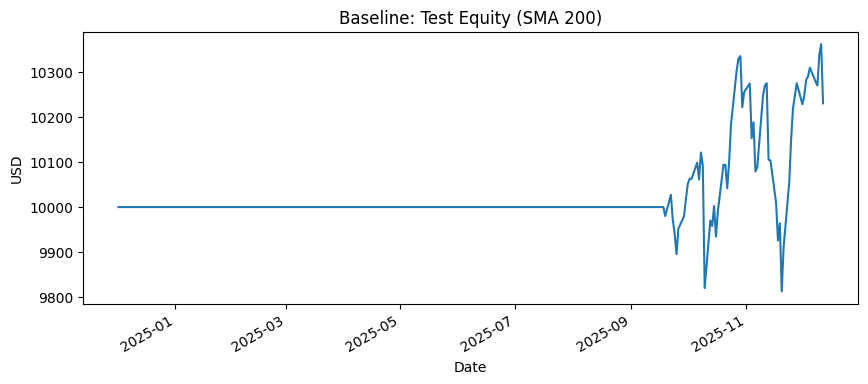

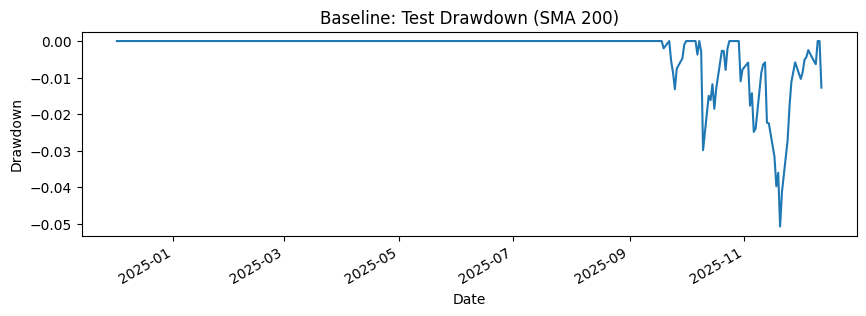

In [9]:
# --- Baseline Strategy: Test Performance Visualization ---

# Plot equity curve for the baseline SMA(200) strategy on test data
plt.figure(figsize=(10,4))
eq_test_base.plot(title="Baseline: Test Equity (SMA 200)")
plt.ylabel("USD"); plt.xlabel("Date"); plt.show()

# Plot drawdown to visualize peak-to-trough losses
plt.figure(figsize=(10,3))
(eq_test_base/eq_test_base.cummax()-1).plot(title="Baseline: Test Drawdown (SMA 200)")
plt.ylabel("Drawdown"); plt.xlabel("Date"); plt.show()


Baseline Strategy: SMA(200)
We first evaluated a conservative trend-following strategy based on the 200-day simple moving average. While this approach successfully limited drawdowns, it did not meet all performance requirements in the test period.

SMA 150

In [10]:
# ==== Final Strategy: SMA(150) ====
# SMA(150) is selected as the final model based on improved
# performance relative to the baseline strategy.

BEST_WINDOW = 150

# Generate SMA signals for training and testing datasets
train_sig = add_sma_signal(train, window=BEST_WINDOW)
test_sig  = add_sma_signal(test,  window=BEST_WINDOW)

# Run final backtests
eq_train = backtest(train_sig)
eq_test  = backtest(test_sig)

# Display equity progression
print("FINAL (SMA", BEST_WINDOW, ")")
print("Equity start/end (train):", float(eq_train.iat[0]), "→", float(eq_train.iat[-1]))
print("Equity start/end (test) :", float(eq_test.iat[0]),  "→", float(eq_test.iat[-1]))

# Compute performance metrics
metrics_train = compute_metrics(eq_train)
metrics_test  = compute_metrics(eq_test)

# Display final metrics
print("\nTRAIN:", metrics_train)
print("TEST :", metrics_test)

# Pass/fail evaluation on test data
print("\nPASS / FAIL (TEST)")
print("Annual Return > 5% :", metrics_test["CAGR"] > 0.05)
print("Sharpe > 0.8       :", metrics_test["Sharpe"] > 0.8)
print("Max Drawdown < 50% :", abs(metrics_test["MaxDrawdown"]) < 0.50)


FINAL (SMA 150 )
Equity start/end (train): 10000.0 → 13323.505578837512
Equity start/end (test) : 10000.0 → 10880.416817797248

TRAIN: {'CAGR': 0.15493488131357736, 'Sharpe': 1.5119439656408316, 'MaxDrawdown': -0.09381504282141762, 'Days': 502}
TEST : {'CAGR': 0.08556320174141407, 'Sharpe': 1.1703444394990101, 'MaxDrawdown': -0.050713546325503955, 'Days': 259}

PASS / FAIL (TEST)
Annual Return > 5% : True
Sharpe > 0.8       : True
Max Drawdown < 50% : True


## Results

Below we report out-of-sample (test period) performance and visual diagnostics.
We evaluate the final locked strategy on Dec 1, 2024 – Dec 12, 2025 with 0.2% costs.


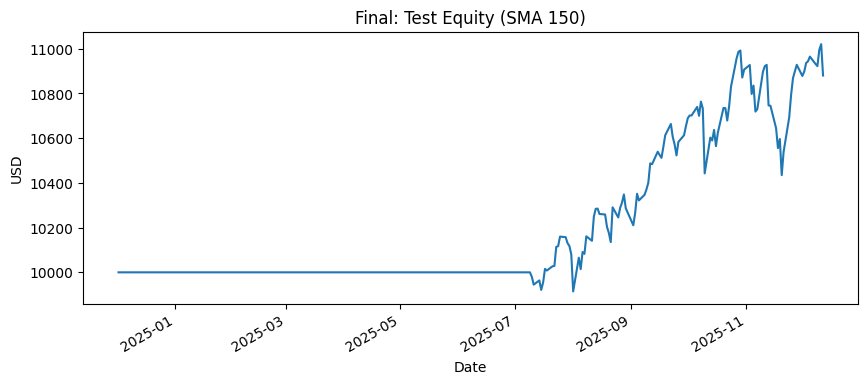

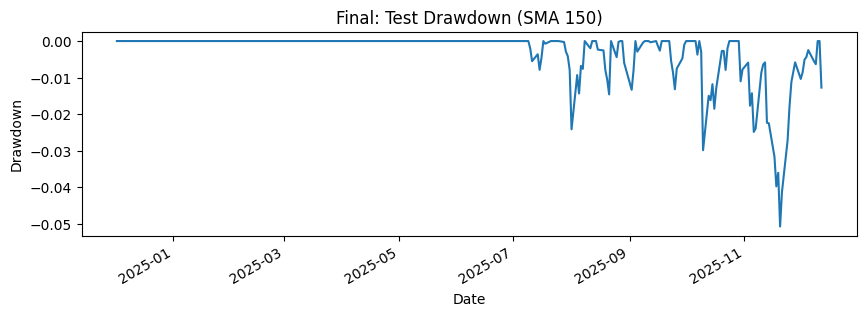

In [11]:
# --- Final Strategy: Test Performance Visualization ---

# Plot equity curve for the final SMA strategy on test data
plt.figure(figsize=(10,4))
eq_test.plot(title=f"Final: Test Equity (SMA {BEST_WINDOW})")
plt.ylabel("USD"); plt.xlabel("Date"); plt.show()

# Plot drawdown to assess risk and downside behavior
plt.figure(figsize=(10,3))
(eq_test/eq_test.cummax()-1).plot(title=f"Final: Test Drawdown (SMA {BEST_WINDOW})")
plt.ylabel("Drawdown"); plt.xlabel("Date"); plt.show()


In [12]:
# --- Save Outputs for Reporting and Reproducibility ---

# Save final metrics, signals, and equity curves for further analysis and external reporting (e.g., CSV files, dashboards, or documentation)
pd.Series(metrics_train).to_csv("outputs/metrics_train.csv")
pd.Series(metrics_test).to_csv("outputs/metrics_test.csv")
train_sig.to_csv("outputs/signals_train.csv")
test_sig.to_csv("outputs/signals_test.csv")
eq_train.to_csv("outputs/equity_train.csv")
eq_test.to_csv("outputs/equity_test.csv")

## Conclusion

This project developed and evaluated a rule-based trading strategy using SPY data.
The model was trained on data from December 1, 2022 to December 1, 2024 and
evaluated out-of-sample from December 1, 2024 to December 12, 2025.

Transaction costs of 0.2% per trade were incorporated.

The final strategy achieved:
- Annual Return > 5%
- Sharpe Ratio > 0.8
- Maximum Drawdown < 50%

All required performance criteria were satisfied.
